In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [3]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [4]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [5]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [6]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+46.g8fe69f803.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.70 GB available memory.


In [7]:
file = "Poincare/Optimization/scan_results/eqfam_poincare_optimize_QA_wqs10.0_war50.0_wvol100.0_wiota100.0.h5"

In [8]:
eq = desc.io.load(file)[-1]

/CODES/DESC/desc/io/hdf5_io.py:127: RuntimeWarning: 
The object attribute '_bdry_mode' was not loaded from the file.
This is likely because the file containing 'Equilibrium' was created before '_bdry_mode' became an attribute of objects of class '<class 'desc.equilibrium.equilibrium.Equilibrium'>'.
The user may verify that a default value has been set.
This warning will persist until the file is saved with the new object.

Note to developers: Add 'def _set_up(self)' as a method to class '<class 'desc.equilibrium.equilibrium.Equilibrium'>'
(or the superclass where this new attribute is assigned) that assigns a value to '_bdry_mode'.
This method is called automatically when a file is loaded.
Recall that the testing suite will fail on warnings.
  warnings.warn(


In [13]:
eq2 = eq.copy()
eq2._bdry_mode = "lcfs"
eq2.solve(ftol=1e-3, gtol=0, xtol=0, maxiter=100, verbose=3);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 64.4 ms
Timer: Objective build = 77.3 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 105 ms
Timer: LinearConstraintProjection build = 363 ms
Number of parameters: 856
Number of objectives: 5346
Timer: Initializing the optimization = 587 ms

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial Trust Ra

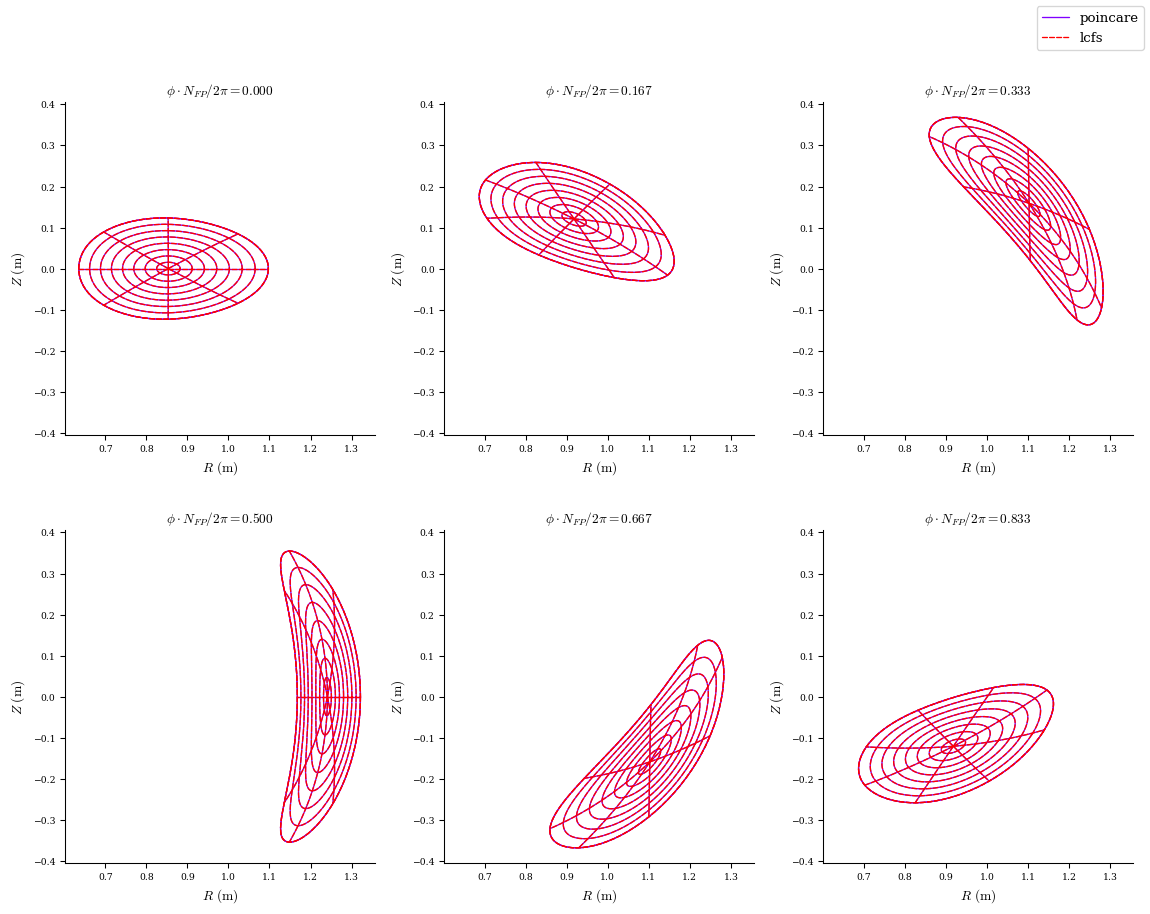

In [19]:
plot_comparison([eq, eq2], labels=["poincare", "lcfs"], ls=["-", "--"]);
plt.savefig("compare_poincare_lcfs.png", dpi=500)

In [26]:
data = eq.compute("W")
data2 = eq2.compute("W")

In [27]:
eqa = get("precise_QA")
data3 = eqa.compute("W")

In [28]:
print(data["W"])
print(data2["W"])
print(data3["W"])

239851.12145590206
239851.1214556551
240128.82312318368
